In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import scipy.stats as stats

In [2]:
raw_data = pd.read_csv("lab2.csv")
raw_data = raw_data.drop(labels=["Unnamed: 13", "Unnamed: 14", "Unnamed: 15", "Unnamed: 16", "Unnamed: 17","Unnamed: 18", "Unnamed: 19", "Unnamed: 20", "Unnamed: 21", "Unnamed: 22", "Unnamed: 23", "Unnamed: 24", "Unnamed: 25", "Unnamed: 26", "Unnamed: 27"], axis=1, inplace=False, errors='raise')
raw_data = raw_data.drop(axis=0, index=range(24, 99))
raw_data = raw_data.drop(axis=0, index=[998])
raw_data.columns = raw_data.iloc[0, :]
raw_data = raw_data.drop(axis=0, index=[0])
raw_data = raw_data.dropna(axis=0, how='all')
raw_data = raw_data.dropna(axis=1, how='all')
raw_data.head(5)

,PWM,Frequency,Period,nan,Angular velocity,PWM,Frequency,Period,nan,Angular velocity,Velocity Left (mm/s),Velocity Right (mm/s)
1,0,1.2,0.83,1.2,7.539822369,0,1.3,0.77,-1.3,-8.168140899,150.7964474,-163.362818
2,10,1.2,0.83,1.2,7.539822369,10,1.3,0.77,-1.3,-8.168140899,150.7964474,-163.362818
3,20,1.2,0.83,1.2,7.539822369,20,1.3,0.77,-1.3,-8.168140899,150.7964474,-163.362818
4,30,1.2,0.83,1.2,7.539822369,30,1.3,0.77,-1.3,-8.168140899,150.7964474,-163.362818
5,40,1.2,0.83,1.2,7.539822369,40,1.3,0.77,-1.3,-8.168140899,150.7964474,-163.362818


In [203]:
column_names = [""]
PI = np.pi
radius = 5 # TODO: CHECK 
d = radius
dt = 0.1 # time interval

actuator_error_x = [0, 7.9]
actuator_error_y = [0, 8.2]
actuator_error_t = [0, 0.07]
actuator_error_w = [0, 0.06]

sensor_error_front = [0, 5.1]
sensor_error_side = [0, 4.7]
sensor_error_t = [0, 0.07]
sensor_error_w = [0, 0.13]

# Box dimensions
L = 1000 # for X
W = 1000 # for Y


STEP 1: The following two functions map the actuator inputs (PWM) to the
velocity inputs (V_left and V_right). There is no noise here, as
most noise is likely to be due to human error in collecting the velocity data//
rather than due to equipment variation and any noise here due to hardware can//
be characterized in STEP 3 when finding the state.

In [4]:
"""
STEP 1 (data-driven): 
The following two functions map the actuator inputs (PWM) to the
velocity inputs (V_left and V_right). There is no noise here, as
most noise is likely to be due to human error in collecting the velocity data
rather than due to equipment variation and any noise here due to hardware can
be characterized in STEP 3 when finding the state.
"""

def pwm_velocity_Left(pwm):
    if 0<=pwm<60:
        return 151.0
    if 60<=pwm<70:
        return 151 - 0.7*(pwm - 60)
    if 70<=pwm<75:
        return 144 - 6.2*(pwm - 70)
    if 75<=pwm<80:
        return 113 - 2.6*(pwm - 75)
    if 80<=pwm<85:
        return 100 - 15.0*(pwm - 80)
    if 85<=pwm<90:
        return 25 - 5.0*(pwm - 85)
    if 90<=pwm<95:
        return 0.0
    if 95<=pwm<100:
        return 0 - 5.0*(pwm - 95)
    if 100<=pwm<105:
        return -25 - 15.0*(pwm-100)
    if 105<=pwm<110:
        return -100 - 5.0*(pwm-105)
    if 110<=pwm<120:
        return -125 - 1.3*(pwm-110)
    if 120<=pwm<130:
        return -138 - 1.3*(pwm-120)
    if 130<=pwm<=180:
        return -151.0
    
def pwm_velocity_Right(pwm):
    if 0<=pwm<50:
        return -163.0
    if 50<=pwm<60:
        return -163 + 1.2*(pwm - 50)
    if 60<=pwm<70:
        return -151 + 2.0*(pwm - 60)
    if 70<=pwm<75:
        return -131 + 6.0*(pwm - 70)
    if 75<=pwm<80:
        return -100 + 20.0*(pwm - 75)
    if 80<=pwm<90:
        return 0.0
    if 90<=pwm<95:
        return 0 + 17.6*(pwm - 90)
    if 95<=pwm<100:
        return 88 + 2.4*(pwm - 95)
    if 100<=pwm<105:
        return 100 + 7.6*(pwm - 100)
    if 105<=pwm<110:
        return 138.0
    if 110<=pwm<120:
        return 138 + 1.2*(pwm - 110)
    if 120<=pwm<130:
        return 150.0
    if 130<=pwm<140:
        return 150 + 0.7*(pwm - 130)
    if 140<=pwm<=180:
        return 157.0

In [5]:
"""
STEP 2 (mathematical model):
This step maps V_left and V_right inputs into the state x = [pos_x, pos_y, theta, omega] 
using mathematical formulations. There is no noise yet at this step.
"""

# x_old = [pos_x, pos_y, theta, omega]
def vel_to_state(v_left, v_right, x_old):
    pos_x, pos_y, theta, omega = x_old
    
    vel = (v_left + v_right)/2
    
    # theta is in radians
    vel_x = - vel * np.cos(theta)
    vel_y = - vel * np.sin(theta)
    omega = (v_right - v_left) / (2 * radius)
#     print("Your v_x is: %f, your v_y is: %f, your omega is: %f" %(vel_x, vel_y, omega))
    
    pos_x += vel_x * dt
    pos_y += vel_y * dt 
    theta += omega * dt 
    
    while theta < 0:
        theta += 2 * PI
    
    while theta > 2 * PI:
        theta -= 2 * PI
    
    return [pos_x, pos_y, theta , omega]

In [6]:
"""
STEP 3 (data-driven model):
This step compares the mathematical model to actual data to find
the mean and variance of the error, then adds this to the state.
"""

def get_actuator_error():
    error_x = np.random.normal(loc=actuator_error_x[0],
                             scale=actuator_error_x[1], 
                             size=None)
    error_y = np.random.normal(loc=actuator_error_y[0],
                             scale=actuator_error_y[1], 
                             size=None)
    error_t = np.random.normal(loc=actuator_error_t[0],
                         scale=actuator_error_t[1], 
                         size=None)
    error_w = np.random.normal(loc=actuator_error_w[0],
                     scale=actuator_error_w[1], 
                     size=None)
    
    return [error_x, error_y, error_t, error_w]

def add_actuator_error(x_old):
    error_x, error_y, error_t, error_w = get_actuator_error()
    pos_x, pos_y, theta, omega = x_old
    
    pos_x += error_x
    pos_y += error_y
    theta += error_t
    omega += error_w
    
    return [pos_x, pos_y, theta, omega]

In [7]:
"""
STEP 4 (data-driven model):
Maps raw sensor readings to meaningful distance/orientation/angular 
acceleration data. 
"""

def raw_to_measured(z_raw):
    lidar1, lidar2, mag_x, mag_y, gyro = z_raw
    
    # offset from calibration
    d_front = lidar1 + 3
    d_side = lidar2 + 25
    
    # offsets and scales from calibration
    mag_x = (mag_x + 155) * 5.7
    mag_y = (mag_y - 105) * 5.9
    
    # due to flipped sensors
    mag_x, mag_y = mag_y, mag_x
    
    theta = np.arctan2(-mag_y, mag_x)
    omega = gyro
    
    return [d_front, d_side, theta, omega]



In [8]:
"""
STEP 5 (mathematical model):
Given a state, calculate what the sensor readings should be.
NOTE: We have converted the sensor outputs mag_x and mag_y into theta, as we feel that is a more
relevant measurement to this lab.
"""

def get_measurements(x):
    return state_to_output(x)

def state_to_output(x):
    pos_x, pos_y, theta, omega = x
    
    # Limit theta to 90 degrees for calculation purposes, as we use
    # right triangles to calculate the distances (d1, d2, d3 and d4)
    theta2 = theta
    while theta2 > PI / 2:
        theta2 -= PI / 2
    
    # Front sensor equations
    d1 = (L - pos_x)/np.cos(theta2)
    d2 = (W - pos_y)/np.sin(theta2)
    d3 = pos_x/np.cos(theta2)
    d4 = pos_y/np.sin(theta2)
    
    # Side sensor equations
    l1 = (L - pos_x)/np.sin(theta2)
    l2 = (W - pos_y)/np.cos(theta2)
    l3 = pos_x/np.sin(theta2)
    l4 = pos_y/np.cos(theta2)
    
    # Calculate the front and side lidar readings based off of different situations: 
    #    1) use which quadrant theta is in to select two relevant distance equations
    #    2) use the closest distance equation as the lidar sensor reading
    
    front = -1
    side = -1
    
    if theta == 0:
        front = pos_x
        side = W - pos_y
    if theta == PI/2:
        front = pos_y
        side = pos_x
    if theta == PI:
        front = L - pos_x
        side = pos_y
    if theta == PI * 3 / 2:
        front = W - pos_y
        side = L - pos_x
        
    if 0 < theta < PI/2:
        front = min(d3, d4)
        side = min(d2, d3)
    if PI/2 < theta < PI:
        front = min(d4, d1)
        side = min(d3, d4)
    if PI < theta < PI * 3 / 2:
        front = min(d1, d2)
        side = min(d4, d1)
    if PI * 3 / 2 < theta < PI * 2:
        front = min(d2, d3)
        side = min(d1, d2)
        
    
    return [front, side, theta, omega]


In [9]:
"""
STEP 6 (Data-driven model):
This step maps sensor readings into the Data-driven model.
It means that now, if we run the simulation multiple time with same input, 
we would get slightly different outputs based on the Gaussian Noise we characterised 
by calculating difference between mathematical model and observed y. 
There is now noise in here.
"""

def get_sensor_error():
    error_front = np.random.normal(loc=sensor_error_front[0],
                             scale=sensor_error_front[1], 
                             size=None)
    error_side = np.random.normal(loc=sensor_error_side[0],
                             scale=sensor_error_side[1], 
                             size=None)
    error_t = np.random.normal(loc=sensor_error_t[0],
                         scale=sensor_error_t[1], 
                         size=None)
    error_w = np.random.normal(loc=sensor_error_w[0],
                     scale=sensor_error_w[1], 
                     size=None)
    
    return [error_front, error_side, error_t, error_w]

def add_sensor_error(z_old):
    front, side, theta, omega = z_old
    error_front, error_side, error_t, error_w = get_sensor_error()
    
    front += error_front
    side += error_side
    theta += error_t
    omega += error_w
    
    return [front, side, theta, omega]

In [10]:
"""
INPUT: An array of PWM inputs to the left and right wheels
       ex: [[PWM_L1, PWM_R1], [PWM_L2, PWM_R2], ... , [PWM_LN, PWM_RN]]
OUTPUT: An array of sensor readings
       ex: [[front1, side1, theta1, omega1], ... , [frontN, sideN, thetaN, omegaN]]
"""
def simulator(pwm, x_initial):
    x = x_initial
    z_history = []
    
    for i in range(len(pwm)):
        v_left, v_right = pwm_velocity_Left(pwm[i][0]), pwm_velocity_Right(pwm[i][1]) # STEP 1
#         print("Your V_Right is: ", v_right, " And V_Left is: ", v_left)
        
        x = vel_to_state(v_left, v_right, x)   # STEP 2
                
        x = add_actuator_error(x)    # STEP 3
        pos_x, pos_y, theta, omega = x
        
#         z_measured = raw_to_measured(z_raw) # STEP 4
#         d_front, d_side, theta, omega = z_measured
        
        z = state_to_output(x) #  STEP 5
        z = add_sensor_error(z) # STEP 6
        z_history += [z]
    
    return z_history

In [11]:
def output_plotter(test_runs, case):
    fig = plt.figure(figsize=(20, 20))
    x_labels = ["Front Distance", "Side Distance", "Theta", "Omega"]
    y_label = "Probability"
    titles = [
        "Front Lidar Distribution (" + case + ")", 
        "Side Lidar Distribution (" + case + ")", 
        "Magnetometer Distribution (" + case + ")", 
        "Gyroscope Distribution (" + case + ")"
    ]

    test_gaus = []
    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1)
        ax.set_xlabel(x_labels[i], fontsize=16)
        ax.set_ylabel(y_label, fontsize=16)
        ax.set_title(titles[i], fontsize=16)
        
        for timestep in range(len(test_runs[0])):
            values = []
            for run in range(100):
                values += [test_runs[run][timestep][i]]

            variance = np.var(values)
            sd = np.sqrt(variance)
            mean = np.mean(values)

            test_gaus += [mean, variance]
            x = np.linspace(mean - 3*sd, mean + 3*sd)
            ax.plot(x, stats.norm.pdf(x, mean, sd))

In [12]:
# Such that in FWD case, vel_Y > 0 and vel_X = 0, i.e. we go UP
x_initial_one = [500, 500, PI * 3 / 2, 0]

steps = 4

# No Movement Test
PWM_REST = [[90, 90]] * steps

# Forward Movement Test (vel_Left = vel_Right)
PWM_FWD = [[0, 130]] * steps

# Clockwise Turn Test
PWM_CW = [[180, 130]] * steps

# CCW Turn Test
PWM_CCW = [[180, 130]] * steps

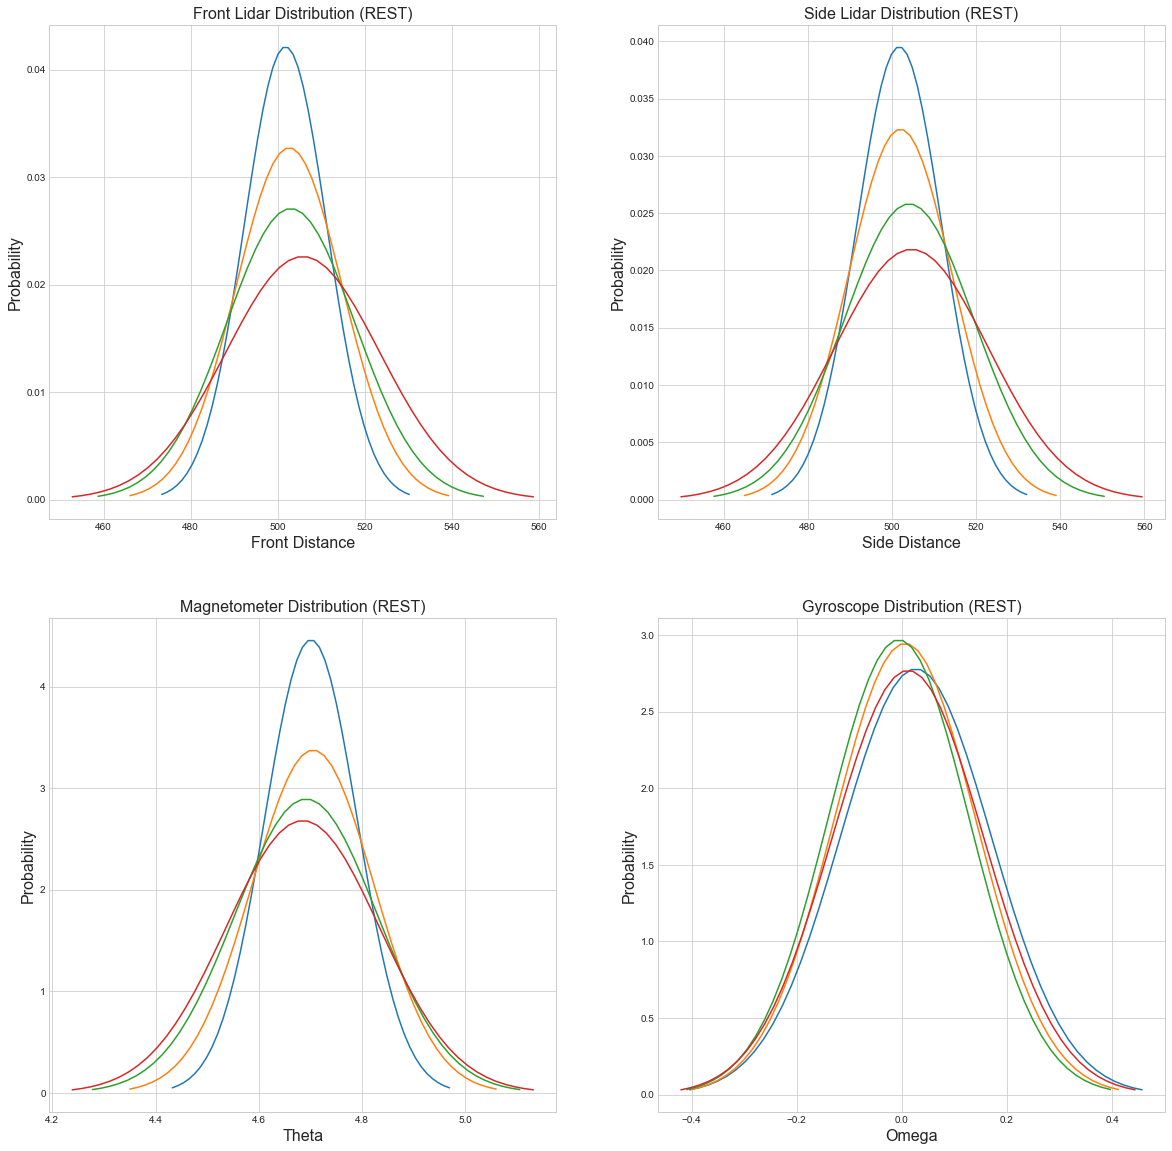

In [13]:
test_runs = [simulator(PWM_REST, x_initial_one) for i in range(100)]
output_plotter(test_runs, "REST")  

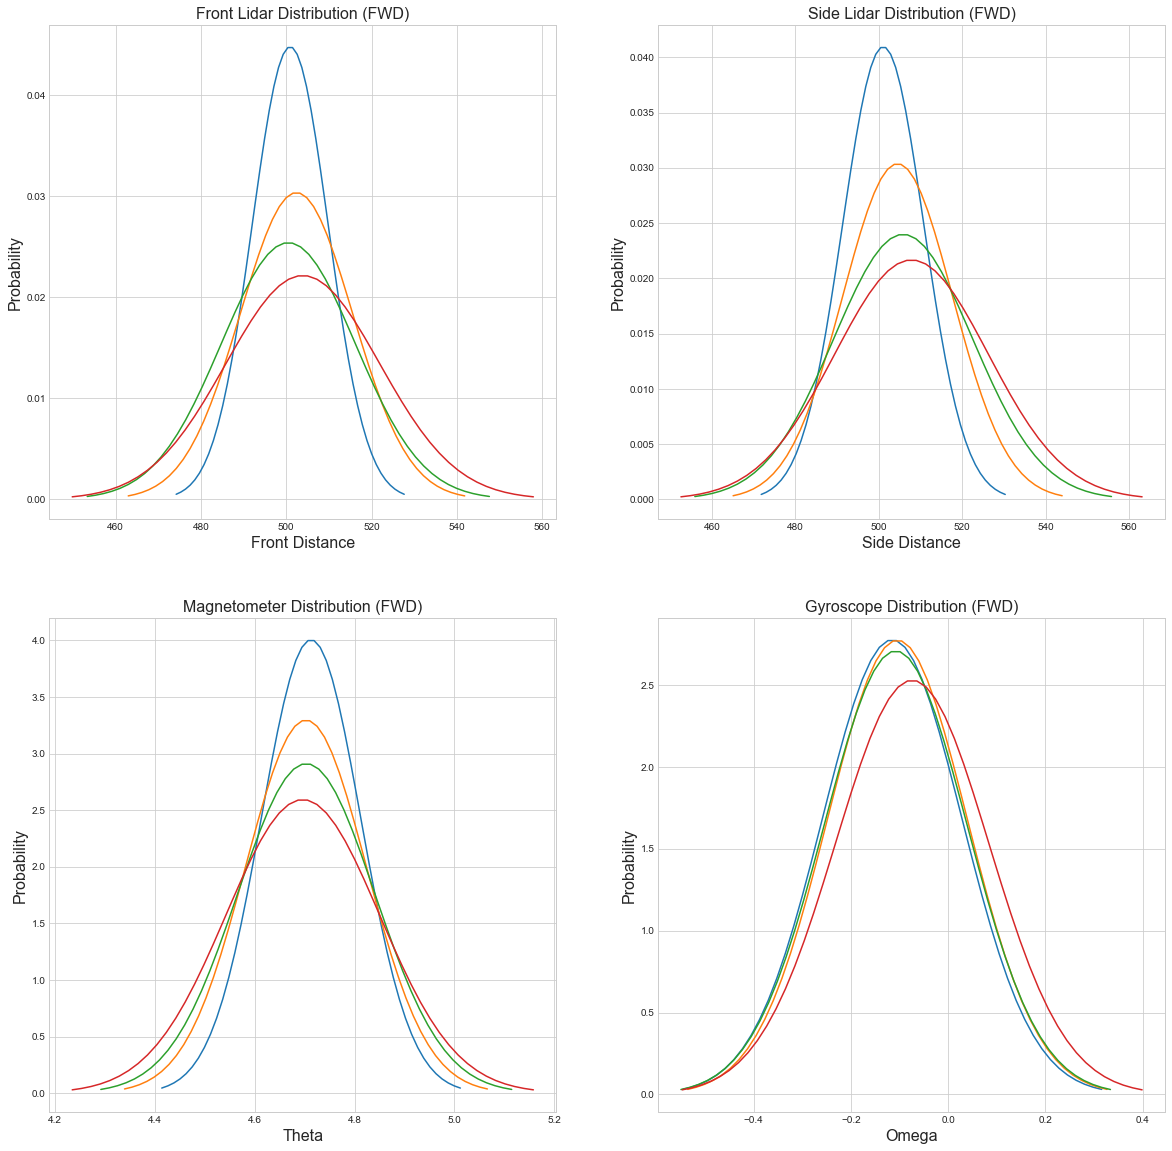

In [14]:
test_runs = [simulator(PWM_FWD, x_initial_one) for i in range(100)]
output_plotter(test_runs, "FWD")  

As time goes on, we get more uncertain because of the noise accumulation, so the distributions flatten out.

We might get suspicious why Side Sensor mean is increasing so much in the FWD case. This is due to the fact that due to noise the car turns a bit, causing the sensor distance to increase. 

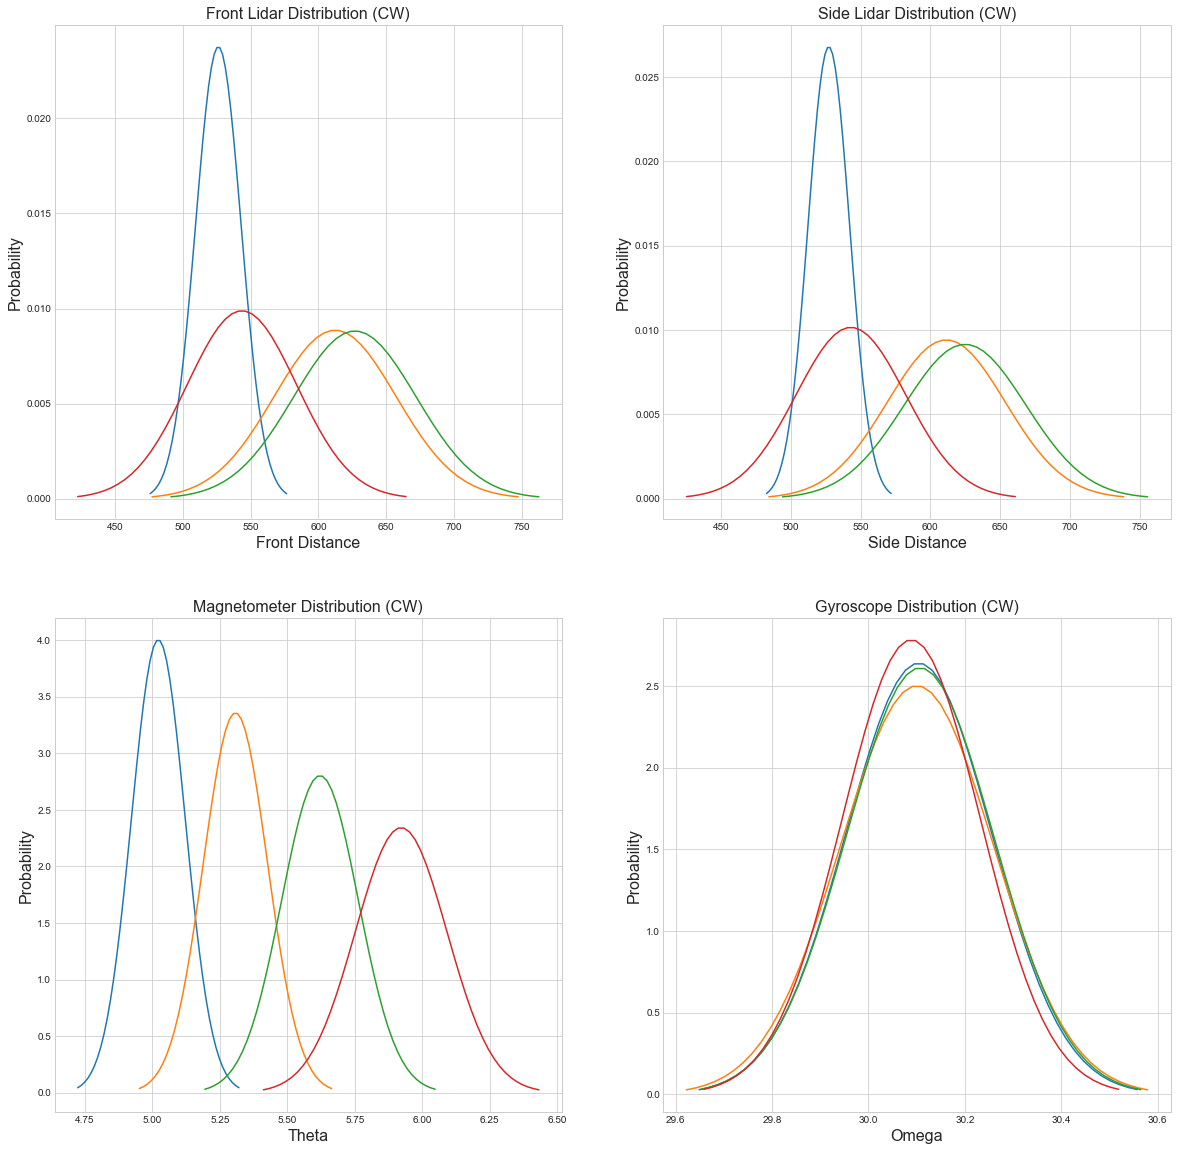

In [15]:
dt = 0.01 # otherwise it spins too fast to get proper angle readings

test_runs = [simulator(PWM_CW, x_initial_one) for i in range(100)]
output_plotter(test_runs, "CW")  

dt = 0.1 # reset

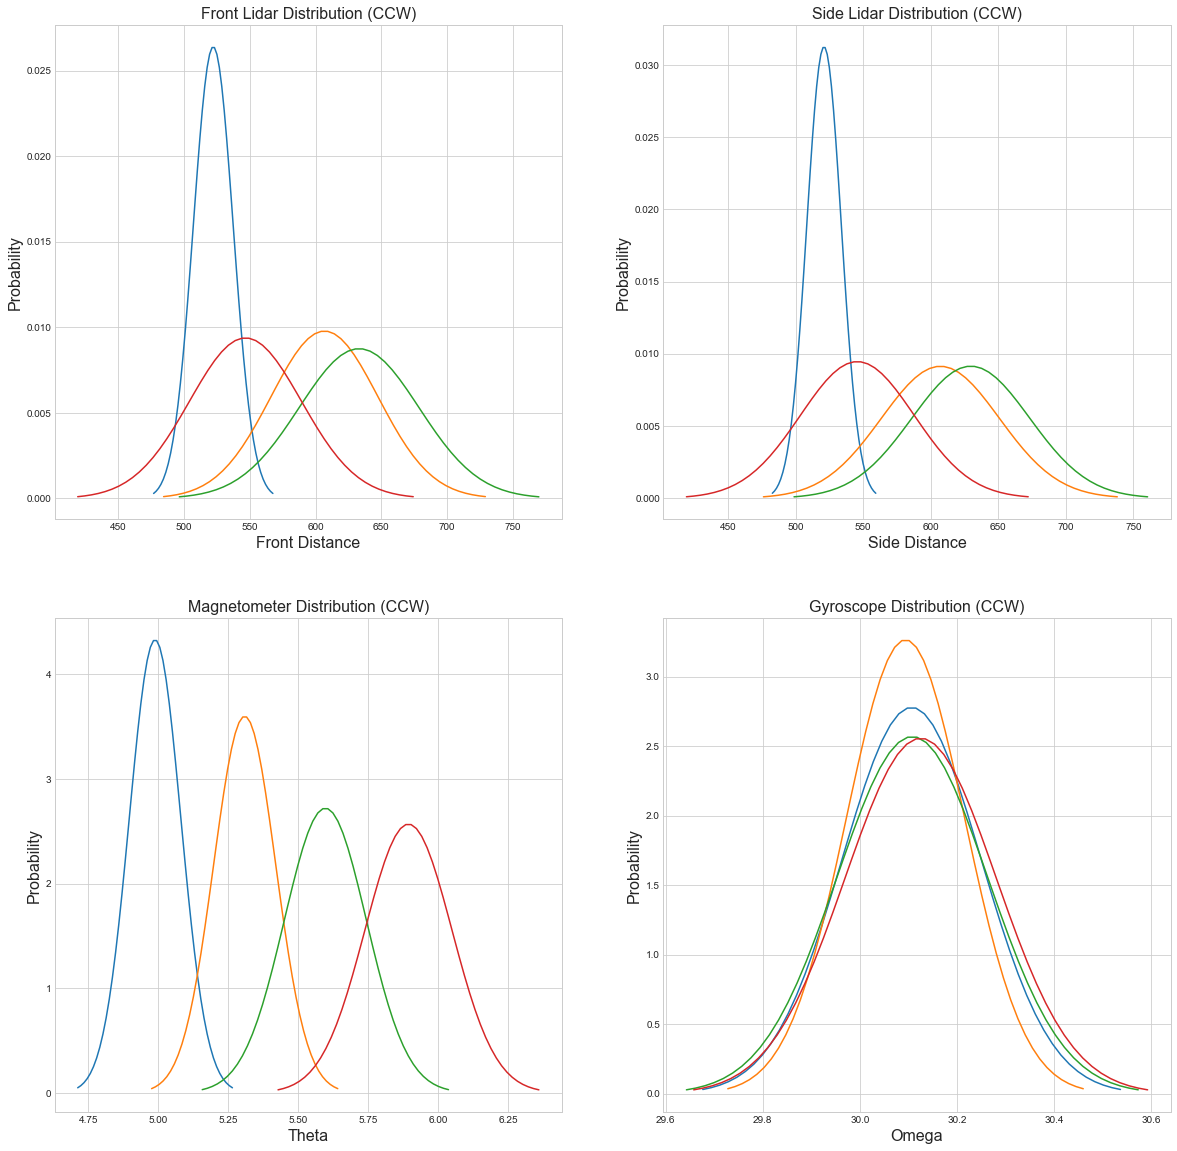

In [16]:
dt = 0.01 # otherwise it spins too fast to get proper angle readings

test_runs = [simulator(PWM_CCW, x_initial_one) for i in range(100)]
output_plotter(test_runs, "CCW")  

dt = 0.1 # reset

In [17]:
""" 
KALMAN FILTER 
"""

' \nKALMAN FILTER \n'

In [65]:
"""
STEP 1: Linearize the matrices for the Dynamic Propagation step using the non-linear function. 
"""

def jacobian_F(x):
    pos_x, pos_y, theta, omega = x
    return np.asarray([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0],
    ])

def jacobian_G(x):
    pos_x, pos_y, theta, omega = x
    
    # Limit theta to 90 degrees for calculation purposes, as we use
    # right triangles to calculate the distances (d1, d2, d3 and d4)
    theta2 = theta
    while theta2 > PI / 2:
        theta2 -= PI / 2
    
    cosT = np.cos(theta2)
    sinT = np.sin(theta2)
    
    return np.asarray([
        [(-cosT / 2) * dt , (-cosT / 2) * dt],
        [(-sinT / 2) * dt , (-sinT / 2) * dt],
        [(1 / (2*d)) * dt , (-1 / (2*d)) * dt],
        [1/(2*d), -1/(2*d)]
    ])

def jacobian_V(x):
    return np.identity(len(x))

def jacobian_W(x):
    return np.identity(len(x))

def jacobian_H(x):
    pos_x, pos_y, theta, omega = x
    
    # Limit theta to 90 degrees for calculation purposes, as we use
    # right triangles to calculate the distances (d1, d2, d3 and d4)
    theta2 = theta
    while theta2 > PI / 2:
        theta2 -= PI / 2
        
    cosT = np.cos(theta2)
    sinT = np.sin(theta2)
    secT = 1.0/cosT
    cscT = 1.0/sinT
    tanT = sinT/cosT
    cotT = cosT/sinT
    
    dsecT = secT * tanT
    dcscT = -cscT * cotT
    
    # Front sensor equations
    d1 = (L - pos_x)/cosT
    d2 = (W - pos_y)/sinT
    d3 = pos_x/cosT
    d4 = pos_y/sinT
    
    # Jacobian Front Sensor Equations
    D1 = [-1/cosT, 0, (L - pos_x) * dsecT, 0]
    D2 = [0, -1/sinT, (W - pos_x) * dcscT, 0]
    D3 = [1/cosT, 0, pos_x * dsecT, 0]
    D4 = [0, 1/sinT, pos_y * dcscT, 0]
    
    # Side sensor equations
    l1 = (L - pos_x)/sinT
    l2 = (W - pos_y)/cosT
    l3 = pos_x/sinT
    l4 = pos_y/cosT
    
    # Jacobian Side Sensor Equations
    D1 = [-1/sinT, 0, (L - pos_x) * dcscT, 0]
    D2 = [0, -1/cosT, (W - pos_x) * dsecT, 0]
    D3 = [1/sinT, 0, pos_x * dcscT, 0]
    D4 = [0, 1/cosT, pos_y * dsecT, 0]
    
    
    # Calculate H1 and H2 rows of the jacobian based off of
    # different situations: 
    #    1) use which quadrant theta is in to select two relevant distance equations
    #    2) use the closest distance equation as the lidar sensor reading
    
    
    H1 = [0,0,0,0]
    H2 = [0,0,0,0]
    
    if theta == 0:
        H1 = [1, 0, 0, 0]
        H2 = [0, -1, 0, 0]
    if theta == PI/2:
        H1 = [0, 1, 0, 0]
        H2 = [1, 0, 0, 0]
    if theta == PI:
        H1 = [-1, 0, 0, 0]
        H2 = [0, 1, 0, 0]
    if theta == PI * 3 / 2:
        H1 = [0, -1, 0, 0]
        H2 = [-1, 0, 0, 0]
        
    if 0 < theta < PI/2:
        if d3 < d4:
            H1 = D3
        else: 
            H1 = D4
            
        if d2 < d3:
            H2 = D2
        else:
            H2 = D3
            
    if PI/2 < theta < PI:
        if d4 < d1:
            H1 = D4
        else: 
            H1 = D1
            
        if d3 < d4:
            H2 = D3
        else:
            H2 = D4
            
    if PI < theta < PI * 3 / 2:
        if d1 < d2:
            H1 = D1
        else: 
            H1 = D2
            
        if d4 < d1:
            H2 = D4
        else:
            H2 = D1
            
    if PI * 3 / 2 < theta < PI * 2:
        if d2 < d3:
            H1 = D2
        else: 
            H1 = D3
            
        if d1 < d2:
            H2 = D1
        else:
            H2 = D2
    
    H3 = [0, 0, 1, 0]
    H4 = [0, 0, 0, 1]
    
    return np.asarray([H1, H2, H3, H4])

In [71]:
"""
STEP 2: Dynamic Propagation Step (t2 is estimate for next timestep, t1 is information from current time step)
  1) x_t2(-) = Fx_t1 + Gx_t1 + v_t1
  2) P_t2(-) = F@P_t1@F^T + V@Q@V^T (this last part is constant because V is identity and Q is constant)
"""

def dp_state_mean(x_t1, u_t1):
    F = jacobian_F(x_t1)
    G = jacobian_G(x_t1)
    v_t1 = get_actuator_error()
    
    x_t2 = F.dot(x_t1) + G.dot(u_t1) + v_t1
    return x_t2

# P_old initially MUST be [0, 0, 0, 0]
def dp_state_var(x_t1, u_t2, P_old):
    F = jacobian_F(x_t1)
    V = jacobian_V(x_t1)
    Q = [
        actuator_error_x[1],
        actuator_error_y[1],
        actuator_error_t[1],
        actuator_error_w[1]
    ]
    
    P_old = np.diag(P_old)
    Q = np.diag(Q)
    V = np.diag(V)
    
    P = (F.dot(P_old)).dot(F.T) + Q #(V.dot(Q)).dot(V.T)
    return np.diag(P)

In [72]:
"""
STEP 3: Measurement Update Step (x_dp is estimate from previous D.P. and x_mu is estimate from M.U.)
"""

def kalman_gain(x_dp, P_dp):
    H = jacobian_H(x_dp)
    W = jacobian_W(x_dp)
    R = [
        sensor_error_front[1],
        sensor_error_side[1],
        sensor_error_t[1],
        sensor_error_w[1]
    ]
#     print(R)
    
    P_dp = np.diag(P_dp)
    W = np.diag(W)
    R = np.diag(R)
    
    P_temp = (H.dot(P_dp)).dot(H.T)
    R_temp = R#(W.dot(R)).dot(W.T)
    temp = np.linalg.inv(P_temp + R_temp)
    
    K = (P_dp.dot(H.T)).dot(temp)
    return K

def mu_state_mean(x_dp, P_dp, z_measured):
    K = kalman_gain(x_dp, P_dp)
    H = jacobian_H(x_dp)
    
    # z_measured = get_measurements(x_dp)
    z_estimate = H.dot(x_dp)
    residual = z_measured - z_estimate
    
    x_mu = x_dp + K.dot(residual)
    return x_mu

def mu_state_var(x_dp, P_dp):
    H = jacobian_H(x_dp)
    W = jacobian_W(x_dp)
    R = [
        sensor_error_front[1],
        sensor_error_side[1],
        sensor_error_t[1],
        sensor_error_w[1]
    ]
    
    W = np.diag(W)
    P_dp = np.diag(P_dp)
    R = np.diag(R)
    
    P_dp_inv = np.linalg.inv(P_dp)
    R_inv = np.linalg.inv(R)
    
#     P_mu_inv = P_dp_inv + (((H.T.dot(W.T)).dot(R_inv)).dot(W)).dot(H)
    P_mu_inv = P_dp_inv + (H.T.dot(R_inv)).dot(H)
    P_mu = np.linalg.inv(P_mu_inv)
    return np.diag(P_mu)

In [190]:
"""
STEP 4: State Estimation using Extended Kalman Filter
Combine the dynamics propagation and measurement update into a chain to create a the state estimator.
"""

def simulator_ekf(pwm, x_initial = [0,0,0,0], P_initial = [0.01, 0.01, 0.02, 0.01]):
    x = x_initial # mean
    P = P_initial # variance
    z = get_measurements(x) # simulates an actual reading
    
    # records the estimates
    #   - even indices are D.P estimates
    #   - odd indices are M.U.s
    x_history = [x, mu_state_mean(x, P, z)]
    P_history = [P, mu_state_var(x, P)]
    
    for i in range(len(pwm)):
        u = [pwm_velocity_Left(pwm[i][0]), pwm_velocity_Right(pwm[i][1])] # CONVERT TO VELOCITY INPUTS
        # Dynamic Propagation Step
        x = dp_state_mean(x, u)
        P = dp_state_var(x, u, P)
        x_history += [x]
        P_history += [P]
                
        # Measurement Update Step
        z = get_measurements(x)
        x = mu_state_mean(x, P, z)
        P = mu_state_var(x, P)
        x_history += [x]
        P_history += [P]
        
    return [x_history, P_history]

In [198]:
def output_plotter_ekf(history, case):
    fig = plt.figure(figsize=(20, 20))
    x_labels = ["X", "Y", "Theta", "Omega"]
    y_label = "Probability"
    titles = [
        "X Distribution (" + case + ")", 
        "Y Distribution (" + case + ")", 
        "Theta Distribution (" + case + ")", 
        "Omega Distribution (" + case + ")"
    ]
    
    # Supports only six plots per graph...which is appropriate for clarity
    style = ["b-", "b--", "g-", "g--", "r-", "r--", "y-", "y--", "b-", "b--", "v-", "v--"]
    x_history = history[0]
    P_history = history[1]
    
    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1)
        ax.set_xlabel(x_labels[i], fontsize=16)
        ax.set_ylabel(y_label, fontsize=16)
        ax.set_title(titles[i], fontsize=16)
        
        for j in range(len(x_history)):
            x = x_history[j][i]
            P = P_history[j][i]
            sd = np.sqrt(P)
            
            x_range = np.linspace(x - 3*sd, x + 3*sd)
            
            ax.plot(
                x_range, np.sqrt(stats.norm.pdf(x_range, x, sd))
            )

In [199]:
# Such that in FWD case, vel_Y > 0 and vel_X = 0, i.e. we go UP
x_initial_one = [500, 500, PI * 3 / 2, 0]

steps = 4

# Forward Movement Test (vel_Left = vel_Right)
PWM_FWD = [[90, 90]] * steps

[500, 500, 4.71238898038469, 0]


[497.87685775 498.04305284   4.71238898   0.        ]


[ 5.07513760e+02  4.99270796e+02  4.64293390e+00 -9.95912492e-02]


[ 5.07513760e+02  4.28705215e-01  4.87502198e-03 -9.95912492e-02]


[ 5.10275052e+02 -6.87374887e-01  1.79217760e-01 -1.17412571e-01]


[ 5.10280136e+02 -2.83924923e+00  1.48343834e-01 -1.17412571e-01]


[ 4.98324133e+02 -3.80693447e-01  2.89144651e-01  6.09233829e-02]


[ 4.98356626e+02 -1.00520947e+00  2.09005969e-01  6.09233829e-02]


[ 4.93169155e+02  1.93076518e+01  1.32269121e-01 -8.53096594e-02]


[ 4.93338365e+02  1.07050993e+02  1.15390465e-01 -8.53096594e-02]




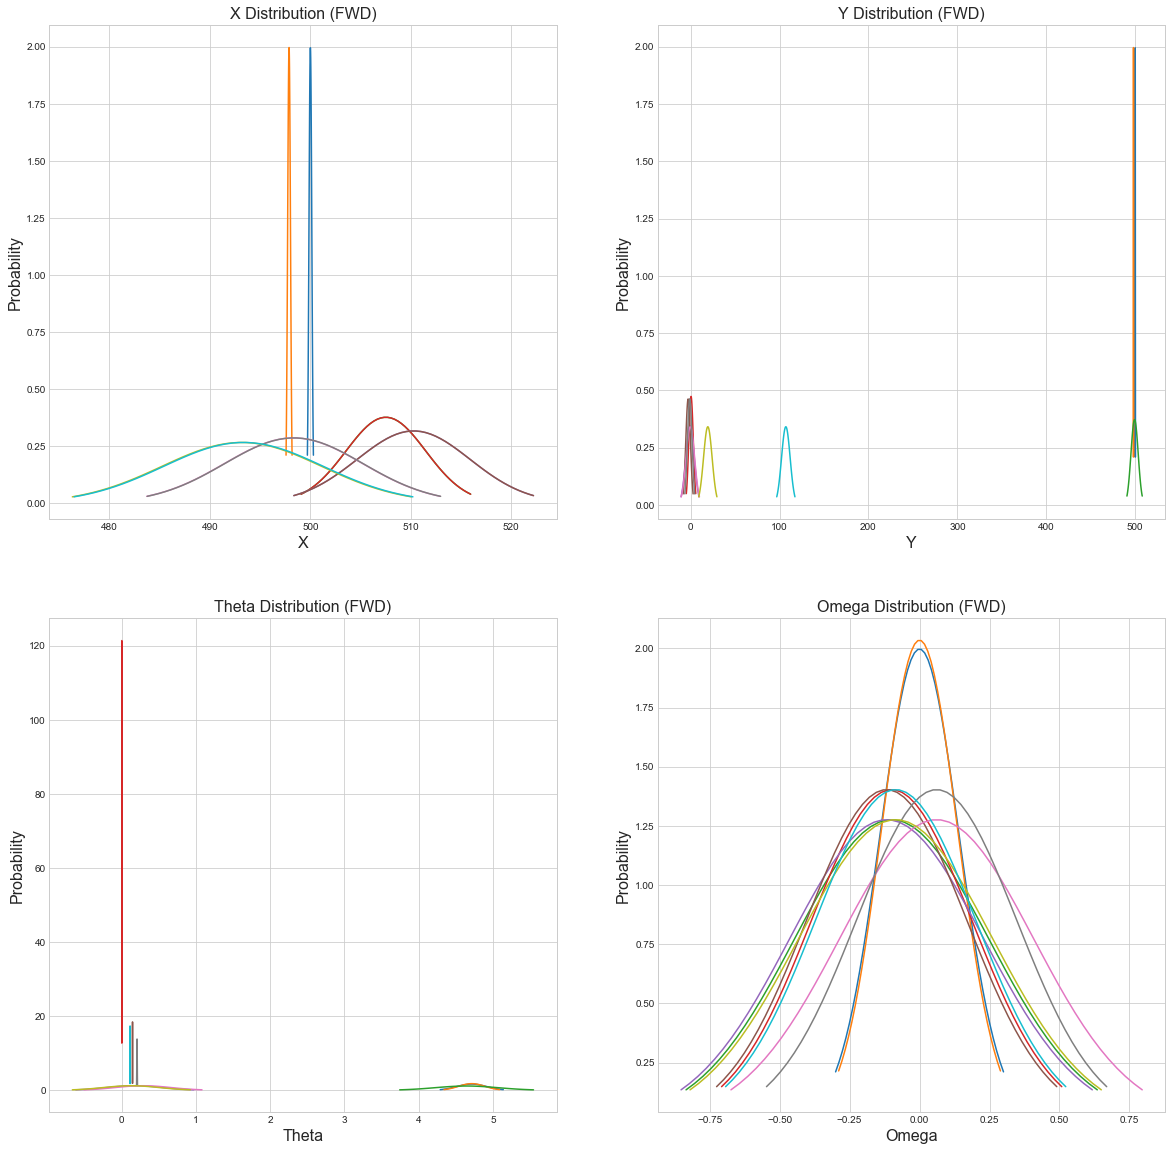

In [211]:
test_run = simulator_ekf(PWM_FWD, x_initial_one)
for i in range(10):
    print(test_run[0][i])
    print("\n")
output_plotter_ekf(test_run, "FWD")